In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk
from joblib import dump, load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../data/Software Requirements Risk Predection.csv


In [2]:
train_filepath = '../data/Software Requirements Risk Predection.csv'

train_df = pd.read_csv(train_filepath)
train_df.head()

,id,requirement_text,project,requirement_category,risk_type,probability,risk_magnitude,risk_impact,risk_dimension,requirement_affected,fixing,fix,fix_priority,req_aff_fix_affects
0,1,The system shall display all the products that...,Transaction Processing System,Functional,Budget,10,Negligible,high,Requirements,9,1,10,95.715385,5
1,2,The system shall allow user to select the prod...,Transaction Processing System,Functional,Quality,22,Very Low,catastrophic,Requirements,7,2,11,35.900000,2
2,3,The system shall display all the available com...,Transaction Processing System,Functional,Schedule,33,Low,high,User,5,1,3,35.692308,2
3,4,The system shall enable user to add one or mor...,Transaction Processing System,Functional,Personal,40,Medium,moderate,Project complexity,D,3,2,44.100000,3
4,5,The system shall notify the user about any con...,Transaction Processing System,Functional,Budget,100,High,Low,planning and control,4,2,1,85.776923,5


# Prelimnary data analysis
Analyze the data and dervice insights and meaning that can be useful for modelling.

[Text(0.5, 0, 'Number of Requirements'), Text(0, 0.5, 'Types of Projects')]

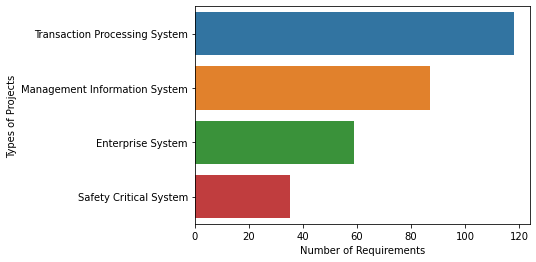

In [3]:
# Requirement and types of project
unique_value_counts = train_df.project.value_counts()
unique_value_index = train_df.project.value_counts().index

req_count_plot = sns.barplot(x=unique_value_counts, y=unique_value_index)
req_count_plot.set(xlabel='Number of Requirements',ylabel='Types of Projects')

[Text(0.5, 0, 'Number of Requirements'),
 Text(0, 0.5, 'Requirement categories')]

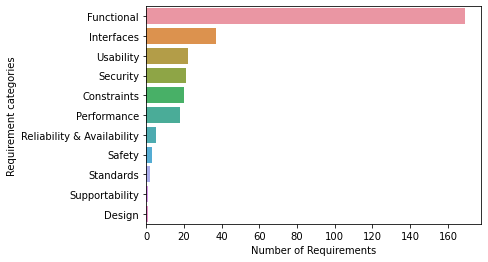

In [4]:
# Requirement types and counts
unique_value_counts = train_df.requirement_category.value_counts()
unique_value_index = train_df.requirement_category.value_counts().index

req_count_plot = sns.barplot(x=unique_value_counts, y=unique_value_index)
req_count_plot.set(xlabel='Number of Requirements',ylabel='Requirement categories')

[Text(0.5, 0, 'Total Count'), Text(0, 0.5, 'Types of Risks')]

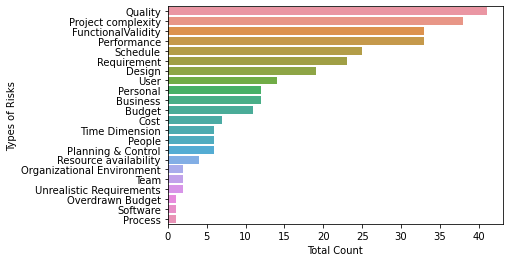

In [5]:
# Risk types and counts
unique_value_counts = train_df.risk_type.value_counts()
unique_value_index = train_df.risk_type.value_counts().index

req_count_plot = sns.barplot(x=unique_value_counts, y=unique_value_index)
req_count_plot.set(xlabel='Total Count',ylabel='Types of Risks')

[Text(0.5, 0, 'Total Count'), Text(0, 0.5, 'Type of Risk Impact')]

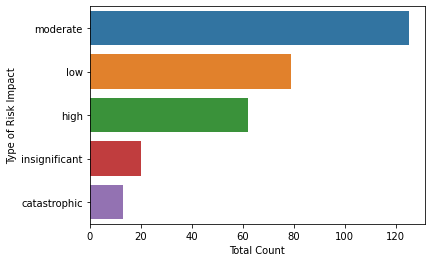

In [6]:
# Risk Impact
train_df['risk_impact'] = train_df['risk_impact'].str.strip()
train_df['risk_impact'] = train_df['risk_impact'].str.lower()

unique_value_counts = train_df.risk_impact.value_counts()
unique_value_index = train_df.risk_impact.value_counts().index

req_count_plot = sns.barplot(x=unique_value_counts, y=unique_value_index)
req_count_plot.set(xlabel='Total Count',ylabel='Type of Risk Impact')

[Text(0.5, 0, 'Total Count'), Text(0, 0.5, 'Type of Risk Impact')]

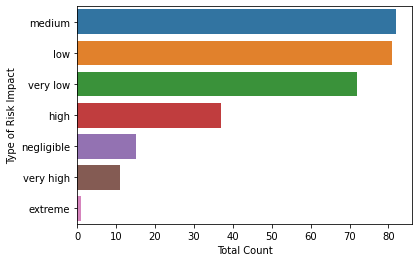

In [7]:
# Risk Magnitude
train_df['risk_magnitude'] = train_df['risk_magnitude'].str.strip()
train_df['risk_magnitude'] = train_df['risk_magnitude'].str.lower()

unique_value_counts = train_df.risk_magnitude.value_counts()
unique_value_index = train_df.risk_magnitude.value_counts().index

req_count_plot = sns.barplot(x=unique_value_counts, y=unique_value_index)
req_count_plot.set(xlabel='Total Count',ylabel='Type of Risk Impact')

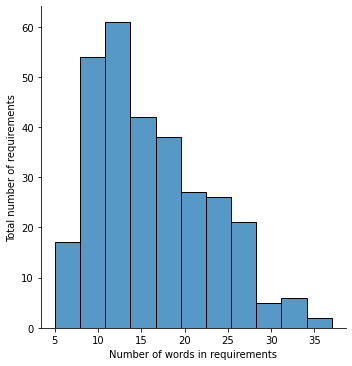

In [8]:
# Length distribution of all the Requirements text
req_len_hist = [len(str(req_text).strip().split()) for req_text in train_df.requirement_text]
req_hist_obj = sns.displot(req_len_hist)
req_hist_obj.set(xlabel='Number of words in requirements',ylabel='Total number of requirements')

[Text(0.5, 0, 'Whitespaced word tokens in Requirements'),
 Text(0, 0.5, 'Number of Tokens')]

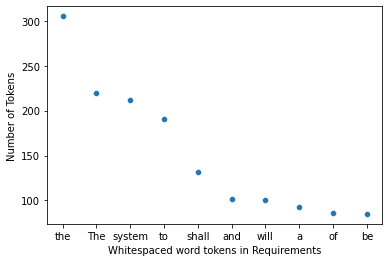

In [9]:
# Top 10 words found in Requirement
wp_tokenizer = nltk.tokenize.WhitespaceTokenizer()
wp_tokens_req = [wp_tokenizer.tokenize(req_text) for req_text in train_df.requirement_text]
all_token_dict = dict()

for token_list in wp_tokens_req:
    for token in token_list:
        if token not in all_token_dict:
            all_token_dict[token] = 1
        else:
            all_token_dict[token] +=1

# Sort and get top 10
sorted_token_dict = {key: value for key, value in sorted(all_token_dict.items(), key=lambda item: item[1],reverse=True)}
top_words = list()
top_values = list()

for key,value in sorted_token_dict.items():
    top_words.append(key)
    top_values.append(value)

req_hist_token = sns.scatterplot(x=top_words[:10],y=top_values[:10])
req_hist_token.set(xlabel='Whitespaced word tokens in Requirements',ylabel='Number of Tokens')

# It can be observed that the most of the words in the requirements are stop words and they can be removed to train better models.

# Modelling and training
Now we have some insight into how these requirements are written and what are the words used. We can train our model to predict risk in new requirements elicited

In [10]:
train_df.head()

,id,requirement_text,project,requirement_category,risk_type,probability,risk_magnitude,risk_impact,risk_dimension,requirement_affected,fixing,fix,fix_priority,req_aff_fix_affects
0,1,The system shall display all the products that...,Transaction Processing System,Functional,Budget,10,negligible,high,Requirements,9,1,10,95.715385,5
1,2,The system shall allow user to select the prod...,Transaction Processing System,Functional,Quality,22,very low,catastrophic,Requirements,7,2,11,35.900000,2
2,3,The system shall display all the available com...,Transaction Processing System,Functional,Schedule,33,low,high,User,5,1,3,35.692308,2
3,4,The system shall enable user to add one or mor...,Transaction Processing System,Functional,Personal,40,medium,moderate,Project complexity,D,3,2,44.100000,3
4,5,The system shall notify the user about any con...,Transaction Processing System,Functional,Budget,100,high,low,planning and control,4,2,1,85.776923,5


In [11]:
# Drop Irrelevant Columns

copy_df = train_df.copy()

cols_to_drop = ['id','project','requirement_category','probability','risk_magnitude','risk_dimension','requirement_affected','fixing','fix','fix_priority','req_aff_fix_affects']
for col in cols_to_drop:
    copy_df.drop(col, axis =1, inplace = True)

In [12]:
# Clean Requirements text column
from nltk.corpus import stopwords
stop = stopwords.words('english')

copy_df['requirement_text'] = copy_df['requirement_text'].str.strip()
copy_df['requirement_text'] = copy_df['requirement_text'].str.lower()

copy_df["requirement_text"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

copy_df.head()

,requirement_text,risk_type,risk_impact
0,the system shall display all the products that...,Budget,high
1,the system shall allow user to select the prod...,Quality,catastrophic
2,the system shall display all the available com...,Schedule,high
3,the system shall enable user to add one or mor...,Personal,moderate
4,the system shall notify the user about any con...,Budget,low


In [13]:
# Using Word Vectors
import spacy

nlp = spacy.load('en_core_web_lg')

# Disable Spacy pipelines and create an array of requirement vectors (Both train and test set)
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in copy_df.requirement_text])
    
doc_vectors.shape

(299, 300)

In [14]:
from sklearn.model_selection import train_test_split

# Test train split on train data
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, copy_df.risk_impact,
                                                    test_size=0.3, random_state=1)

In [15]:
from sklearn.svm import LinearSVC

# Set dual=False to speed up training, and it's not needed
svc = LinearSVC(random_state=1, dual=True, max_iter=1000)
svc.fit(X_train, y_train)

# Tested on the test set
print(f"Accuracy: {svc.score(X_test, y_test) * 100:.3f}%", )
dump(svc, '../models/SVCRequirementRisk.joblib')

Accuracy: 32.222%


['../models/SVCRequirementRisk.joblib']